# Projekt przewidywania temperatury

### Przedmiot projektu

Projekt obejmuje stworzenie algorytmu uczenia maszynowego w celu przewidywania pogody dla miata Szeged na Węgrzech.<br>
Dane były pobierane w przedziale czasowym od 2006-01-01 00:00:00 do 2016-12-31 23:00:00 o każdej pełnej godzine.

In [1]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("weatherHistory.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
# shape of dataframe
df_shape = df.shape
print(f"Dataset weatherHistory posiada {df_shape[1]} cech oraz {df_shape[0]} obserwacji.")

Dataset weatherHistory posiada 12 cech oraz 96453 obserwacji.


In [4]:
# data frame information about features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
pd.DataFrame(df.isna().mean()).T

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,0.0,0.0,0.00536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# description for numerical features
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


#### Wnioski

Data frame posiada wartości NaN dla cechy 'Precip Type', co stanowi 5.3%% (promila) wszystkich danych. <br> <br>

Kolumny kategoryczne: Formatted Date, Summary, Precip Type, Daily Summary <br>
Kolumny numeryczne: Temperature (C), Apparent Temperature (C), Humidity, Wind Speed (km/h), Wind Bearing (degrees), Visibility (km), Loud Cover, Pressure (millibars)

Kolumna Loud Cover posiada tylko wartości 0, dlatego nie jest istotna dla data frame.

## Zamiana pustych wartości 


In [7]:
pd.DataFrame(df.isna().mean()).T

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,0.0,0.0,0.00536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df["Precip Type"].value_counts(dropna=False)

rain    85224
snow    10712
NaN       517
Name: Precip Type, dtype: int64

In [9]:
df_precip_null = df.loc[df["Precip Type"].isnull()]
df_precip_null

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
52672,2012-04-11 16:00:00.000 +0200,Mostly Cloudy,NaN,19.016667,19.016667,0.26,14.8764,163.0,9.982,0.0,1002.40,Mostly cloudy until night.
52674,2012-04-11 18:00:00.000 +0200,Mostly Cloudy,NaN,17.850000,17.850000,0.28,13.7977,169.0,9.982,0.0,1001.79,Mostly cloudy until night.
52675,2012-04-11 19:00:00.000 +0200,Mostly Cloudy,NaN,16.322222,16.322222,0.32,10.8192,151.0,9.982,0.0,1001.60,Mostly cloudy until night.
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,NaN,12.566667,12.566667,0.43,9.0160,159.0,9.982,0.0,1001.92,Mostly cloudy until night.
52678,2012-04-11 22:00:00.000 +0200,Mostly Cloudy,NaN,12.927778,12.927778,0.47,17.6295,197.0,16.100,0.0,1002.20,Mostly cloudy until night.
...,...,...,...,...,...,...,...,...,...,...,...,...
95584,2016-10-31 19:00:00.000 +0100,Mostly Cloudy,NaN,8.322222,7.044444,0.85,8.0339,290.0,0.000,0.0,1021.73,Mostly cloudy starting in the afternoon.
95585,2016-10-31 20:00:00.000 +0100,Mostly Cloudy,NaN,7.627778,6.183333,0.87,8.2271,293.0,0.000,0.0,1021.76,Mostly cloudy starting in the afternoon.
95586,2016-10-31 21:00:00.000 +0100,Mostly Cloudy,NaN,7.111111,5.511111,0.89,8.5008,297.0,0.000,0.0,1021.81,Mostly cloudy starting in the afternoon.
95587,2016-10-31 22:00:00.000 +0100,Partly Cloudy,NaN,6.672222,4.961111,0.90,8.6457,299.0,0.000,0.0,1021.83,Mostly cloudy starting in the afternoon.


In [10]:
temp_max = round(df_precip_null["Temperature (C)"].max(),2)
temp_min = round(df_precip_null["Temperature (C)"].min(),2)
print(f"Temperatura dla brakujących wartości max={temp_max}, min={temp_min}")

Temperatura dla brakujących wartości max=25.04, min=1.26


In [11]:
df["Precip Type"].isnull

<bound method Series.isnull of 0        rain
1        rain
2        rain
3        rain
4        rain
         ... 
96448    rain
96449    rain
96450    rain
96451    rain
96452    rain
Name: Precip Type, Length: 96453, dtype: object>

In [12]:
df.loc[df["Precip Type"] == np.NaN]

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary


In [13]:
df['Precip Type'] = df['Precip Type'].replace(np.NaN, 'rain')
df["Precip Type"].value_counts(dropna=False)

rain    85741
snow    10712
Name: Precip Type, dtype: int64

## Stworzenie kolumn dla miesiąca i godziny

In [14]:
df["Month"] = df["Formatted Date"].apply(lambda x: int(x[5:7]))

In [15]:
df["Hour"] = df["Formatted Date"].apply(lambda x: int(x[11:13]))

## Usuwanie kolumn

In [16]:
for col in df:
    a = df[col].unique()
    if len(a) == 1:
        print(col, a)

Loud Cover [0.]


In [17]:
df = df.drop('Loud Cover', axis=1)

In [18]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Month,Hour
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,4,0
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,4,1
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,4,2
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,4,3
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,4,4


In [19]:
df = df.drop('Formatted Date', axis=1)

In [20]:
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Month,Hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,4,0
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,4,1
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,4,2
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,4,3
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,4,4


## Columny kategoreyczne

In [21]:
# Precip Type column
df = pd.get_dummies(df, columns = ['Precip Type'])
df.rename(columns={'Precip Type_rain': 'Rain', 'Precip Type_snow': 'Snow'}, inplace=True)

In [22]:
def create_summary_columns(column_name, data_frame):
    if column_name not in data_frame.columns:
        data_frame[column_name] = 0
        
separator = " and "
list_of_values = df["Summary"].unique()

# Summary column
# create new columns from Summary unique values
for unique_value in list_of_values:
    if separator in unique_value:
        value_list = unique_value.split(separator)
        for col_name in value_list:
            create_summary_columns(col_name, df)
            df.loc[df["Summary"] == unique_value, col_name] = 1
    else:
        create_summary_columns(unique_value, df)
        df.loc[df["Summary"] == unique_value, unique_value] = 1
df = df.drop('Summary', axis=1)

## Columny kategoreyczne

In [23]:
# Add column with temerature difference between measured and apparent temperature 
df["temperature difference"] = df["Apparent Temperature (C)"] - df["Temperature (C)"]
df = df.drop("Apparent Temperature (C)", axis=1)

In [24]:
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Month,Hour,Rain,...,Foggy,Breezy,Clear,Humid,Windy,Dry,Dangerously Windy,Light Rain,Drizzle,temperature difference
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,4,0,1,...,0,0,0,0,0,0,0,0,0,-2.083333
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,4,1,1,...,0,0,0,0,0,0,0,0,0,-2.127778
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,4,2,1,...,0,0,0,0,0,0,0,0,0,0.000000
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,4,3,1,...,0,0,0,0,0,0,0,0,0,-2.344444
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,4,4,1,...,0,0,0,0,0,0,0,0,0,-1.777778


In [26]:
# # Daily Summary column
df_daily_summary = pd.DataFrame()
df_daily_summary["Count"] = df.groupby(['Daily Summary'])["Daily Summary"].count()
df_daily_summary
df_daily_summary.describe()

,Count
count,214.000000
mean,450.714953
std,1713.287546
min,23.000000
25%,24.000000
50%,24.000000
75%,168.000000
max,20085.000000


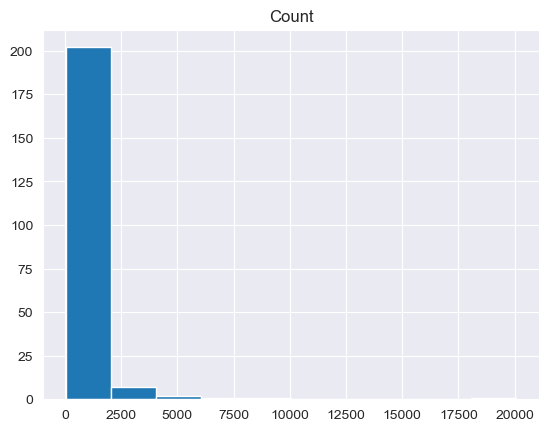

In [27]:
df_daily_summary.hist()
plt.show()

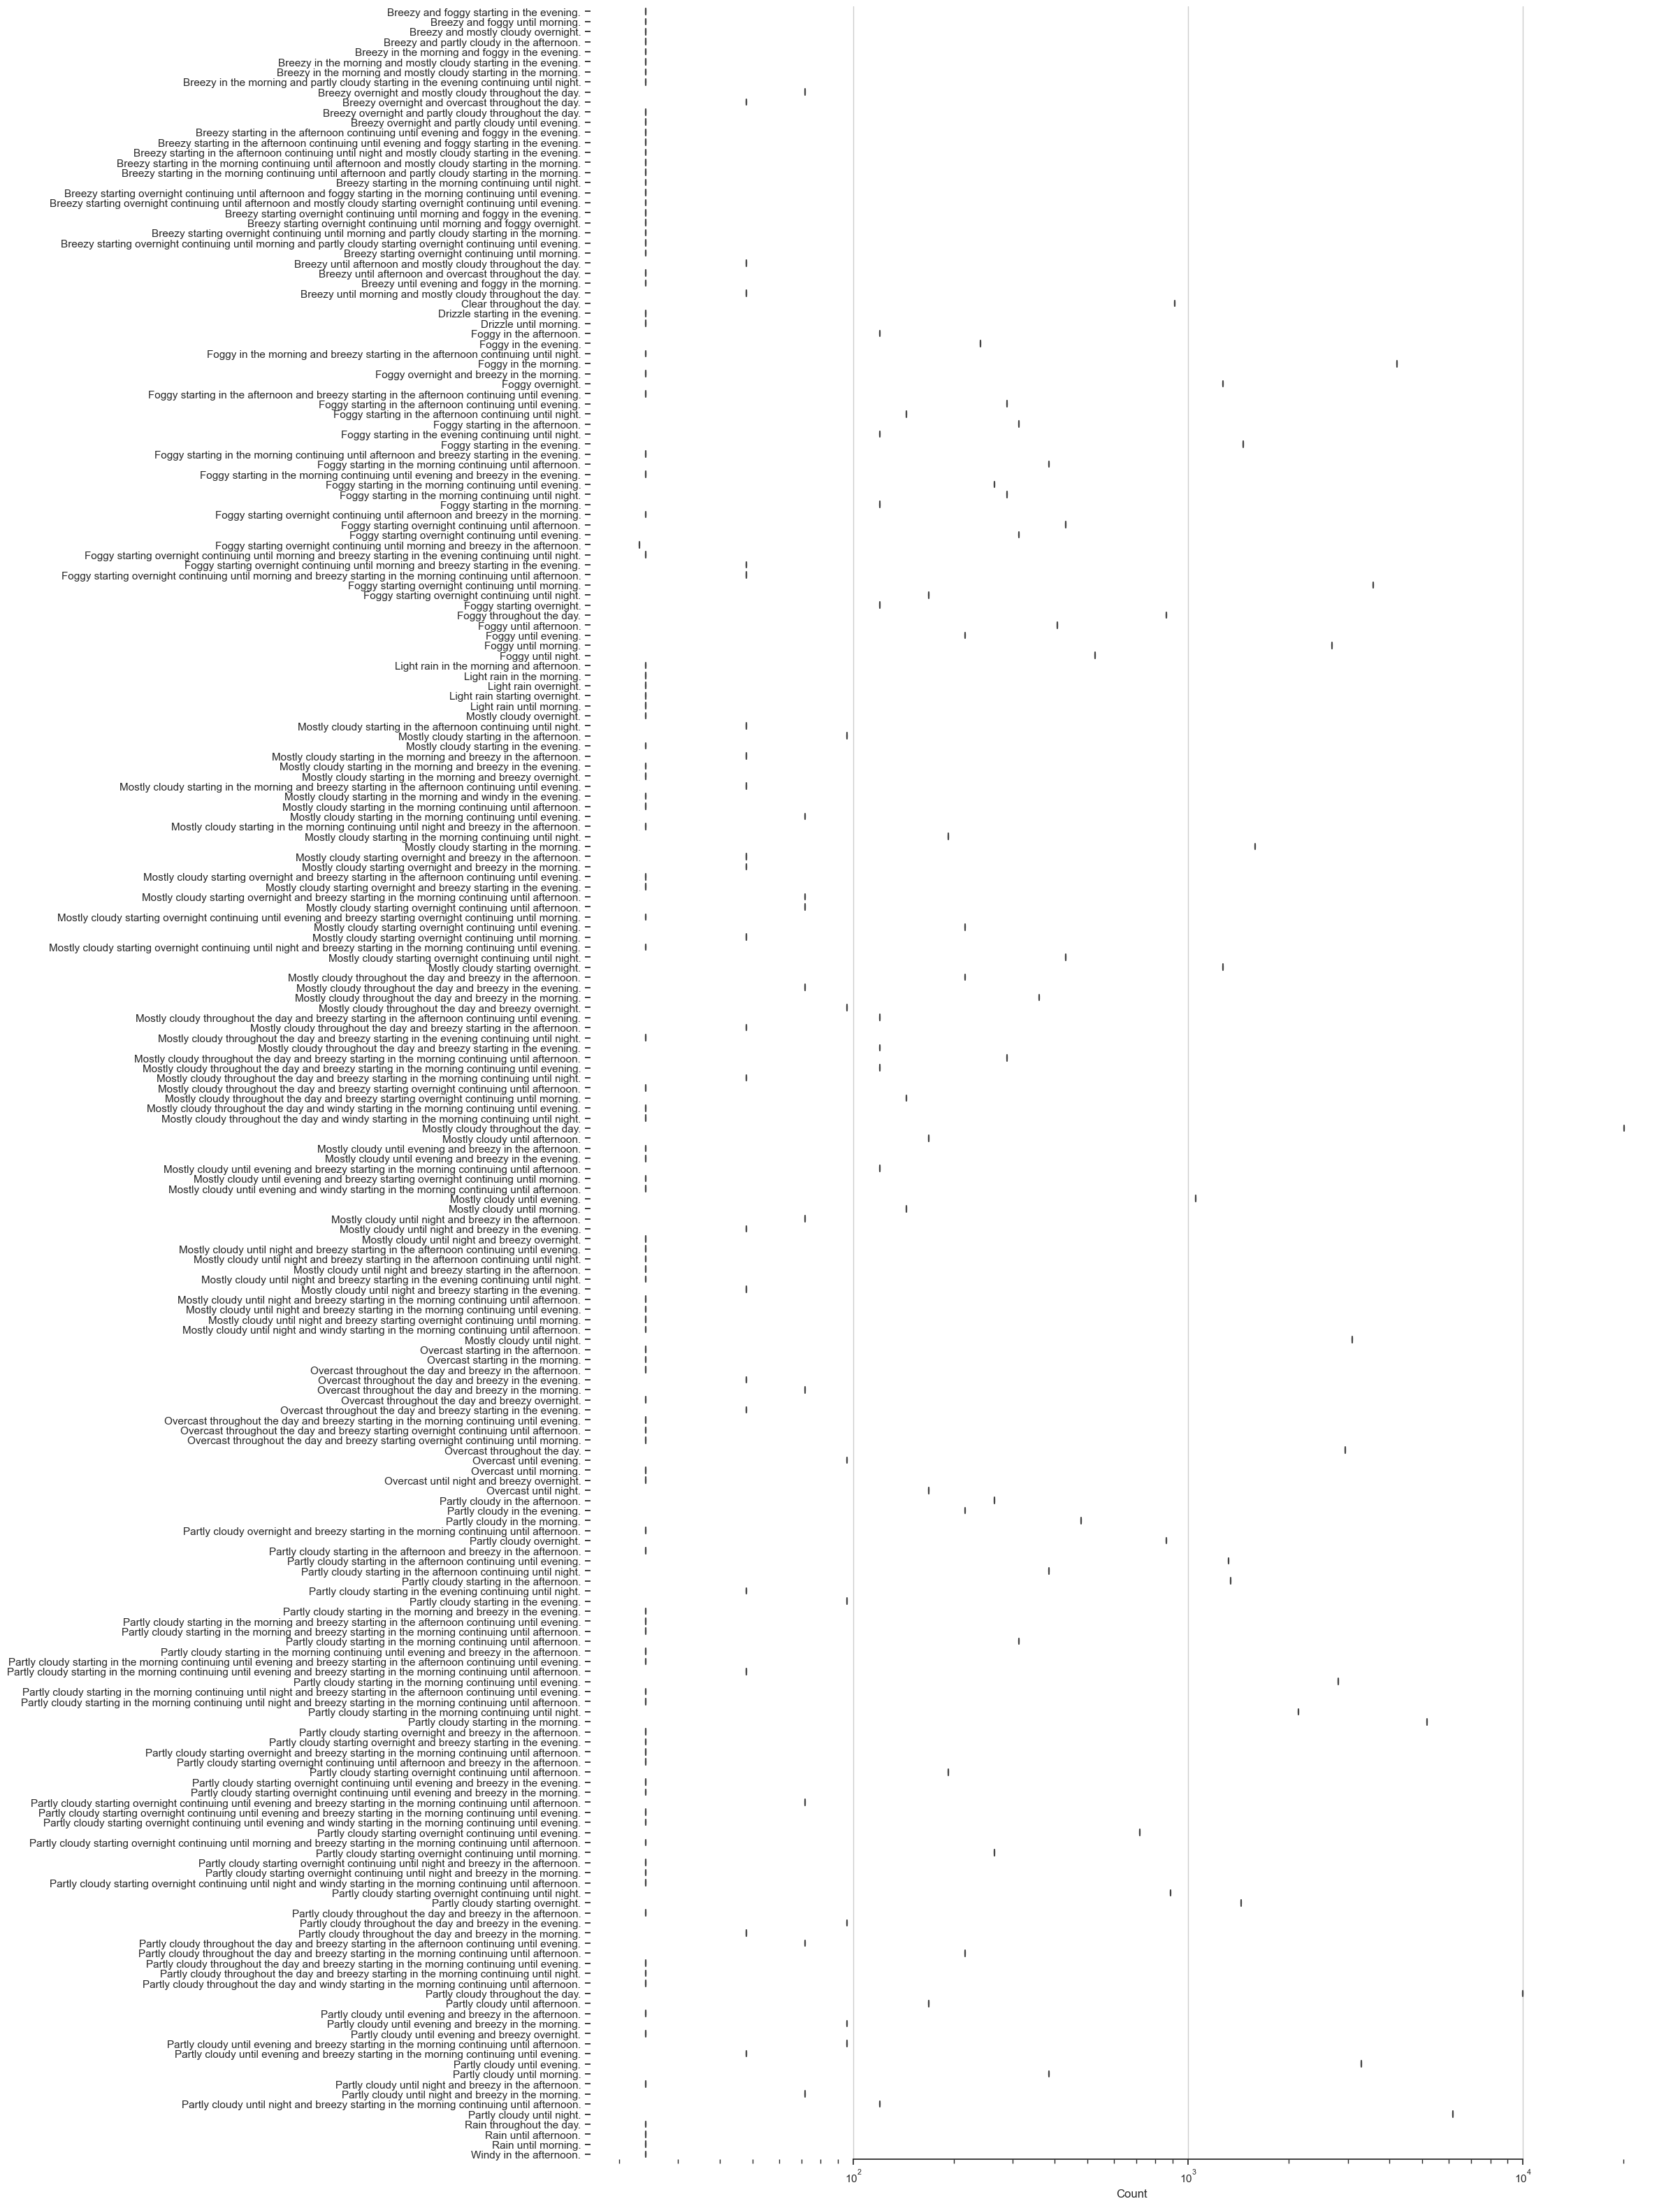

In [28]:
sns.set_theme(style="ticks")
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(20, 40))
ax.set_xscale("log")
# Plot the orbital period with horizontal boxes
sns.boxplot (x="Count", y=df_daily_summary.index, data=df_daily_summary,
            whis=[0, 100], width=.6, palette="vlag")
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [29]:
df = df.drop("Daily Summary", axis=1)

## Analiza wykresów cech

In [30]:
originalFeatures = df.columns
print('originalFeatures count', len(originalFeatures))
print('originalFeatures', originalFeatures)

originalFeatures count 23
originalFeatures Index(['Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
       'Month', 'Hour', 'Rain', 'Snow', 'Partly Cloudy', 'Mostly Cloudy',
       'Overcast', 'Foggy', 'Breezy', 'Clear', 'Humid', 'Windy', 'Dry',
       'Dangerously Windy', 'Light Rain', 'Drizzle', 'temperature difference'],
      dtype='object')


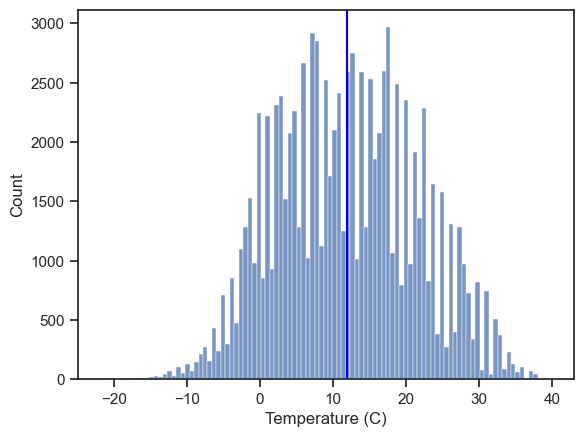

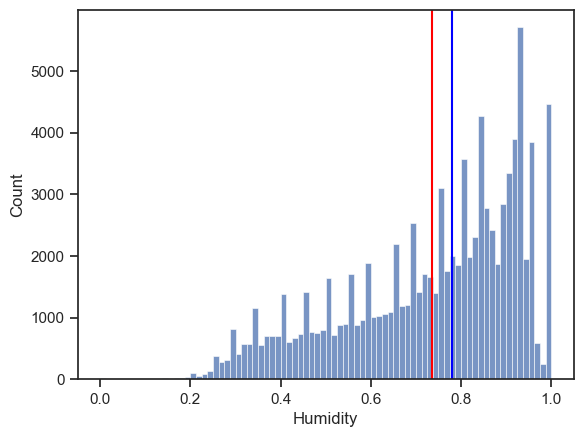

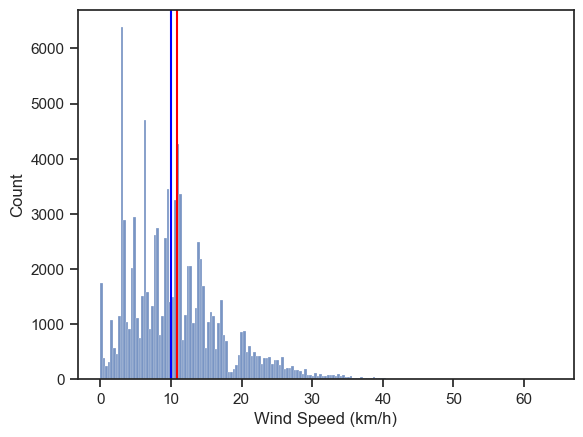

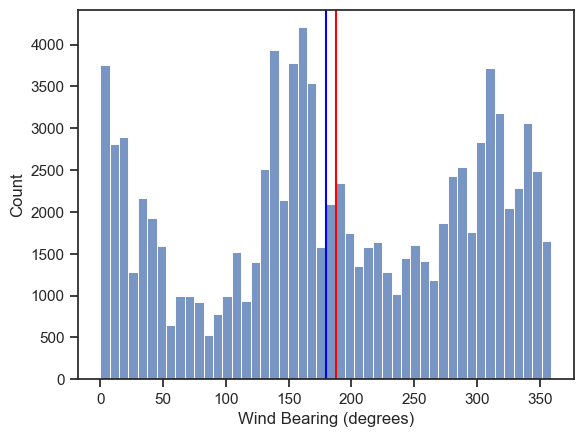

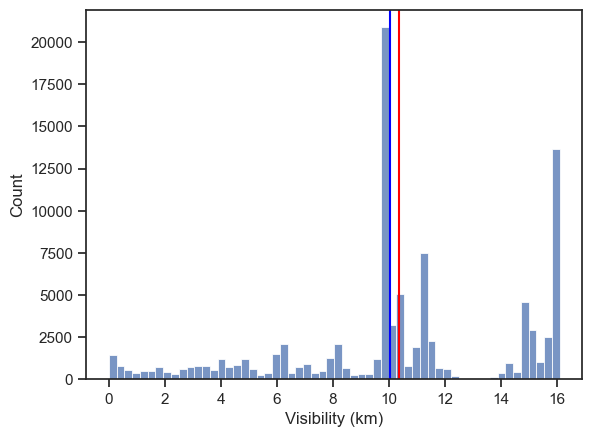

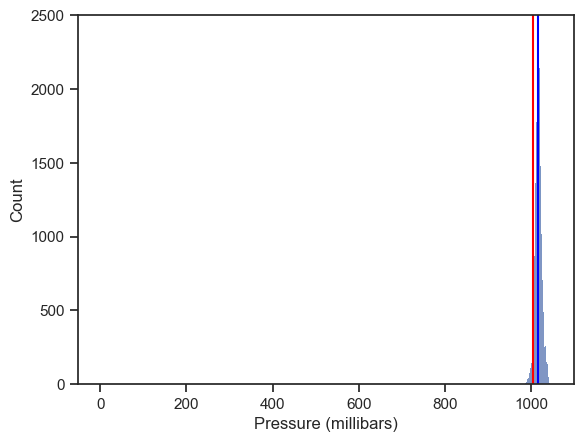

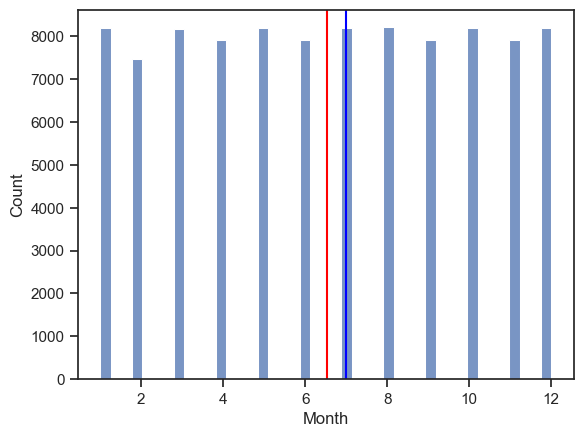

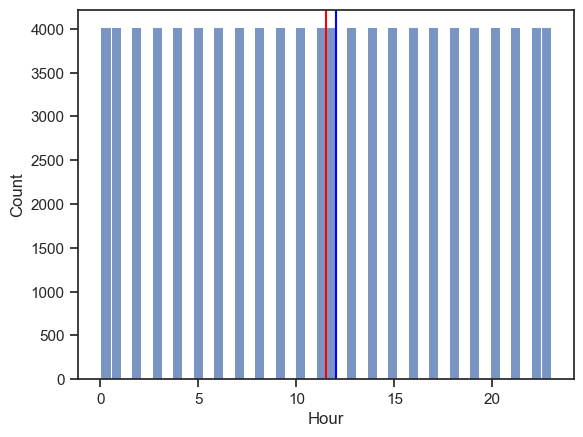

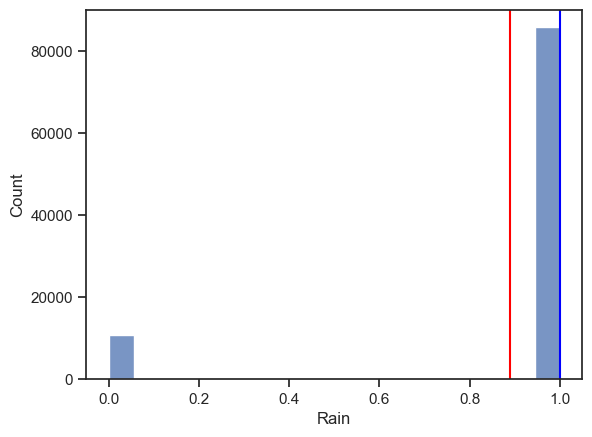

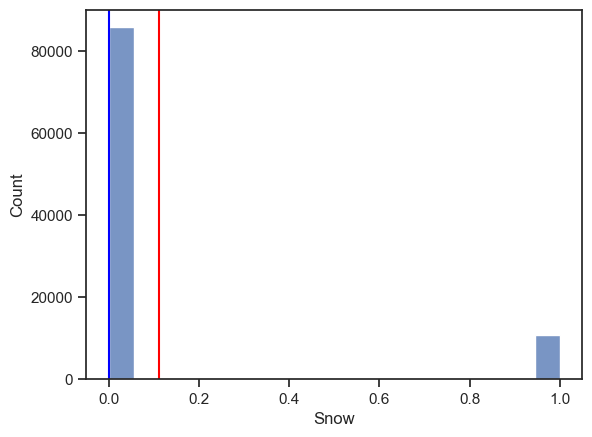

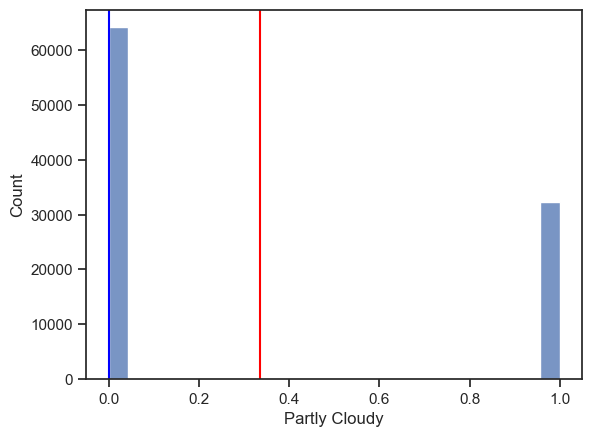

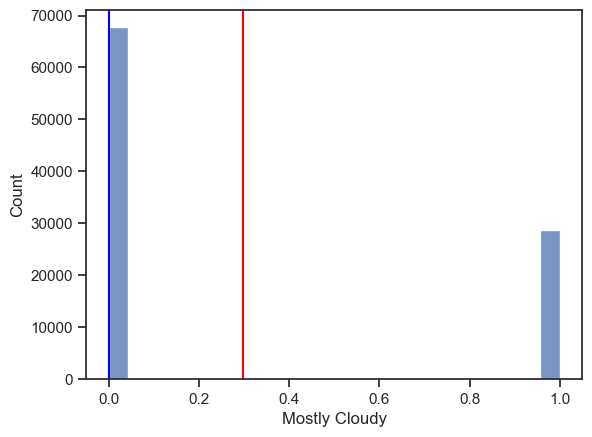

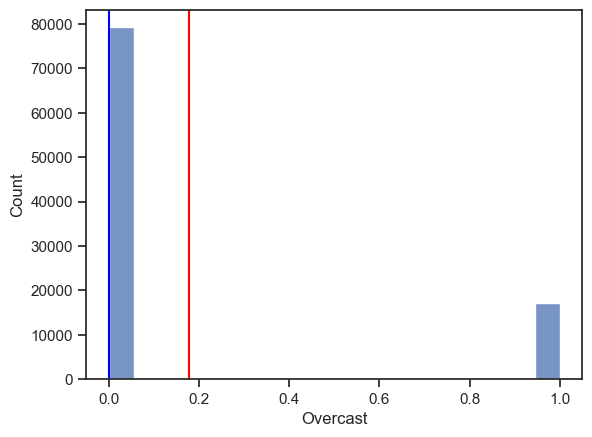

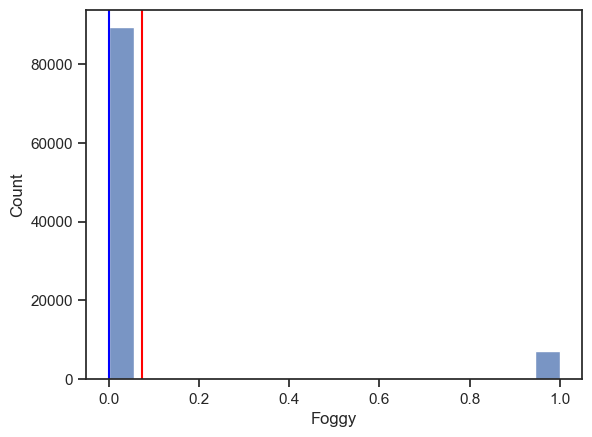

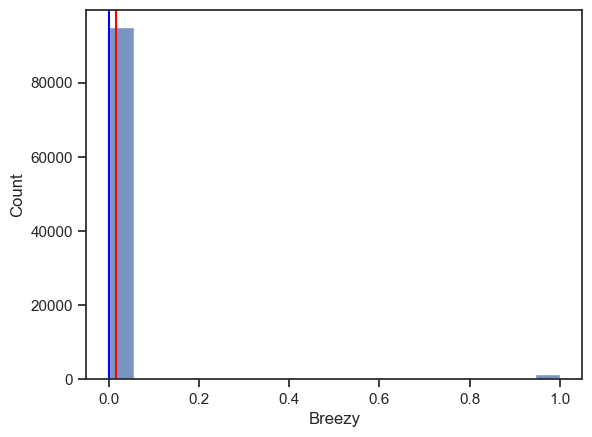

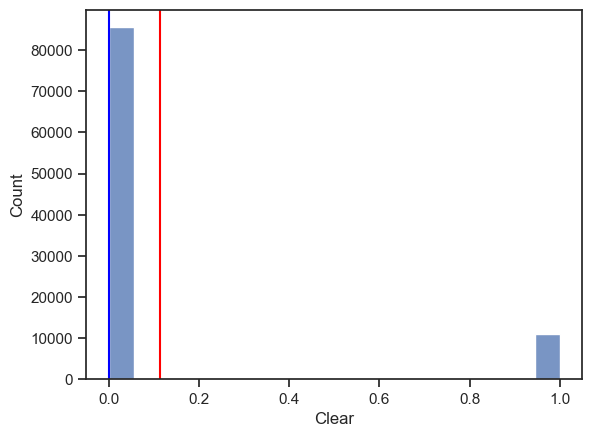

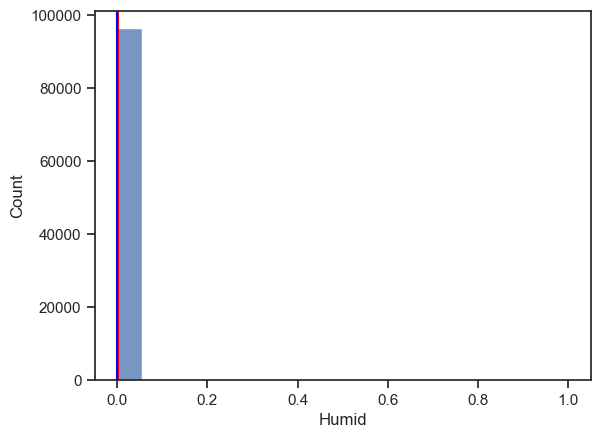

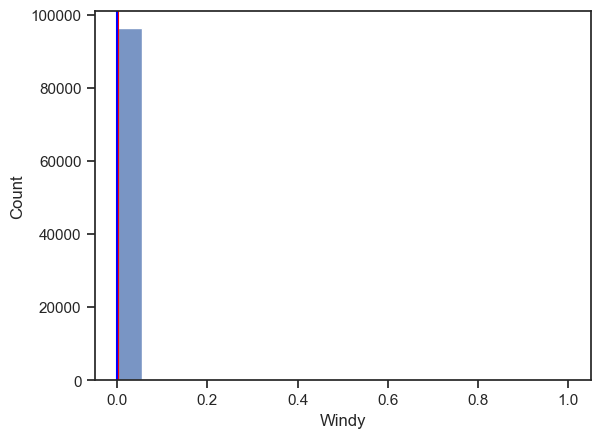

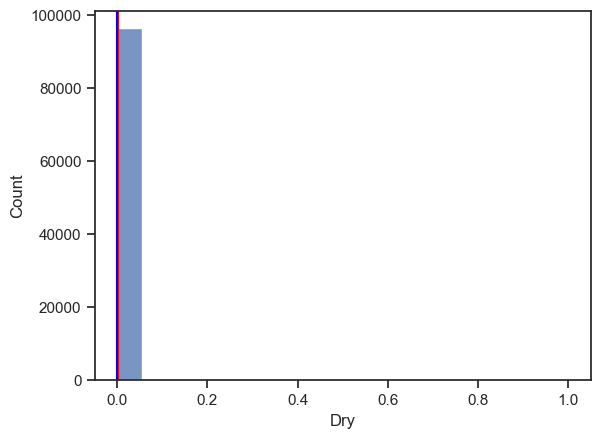

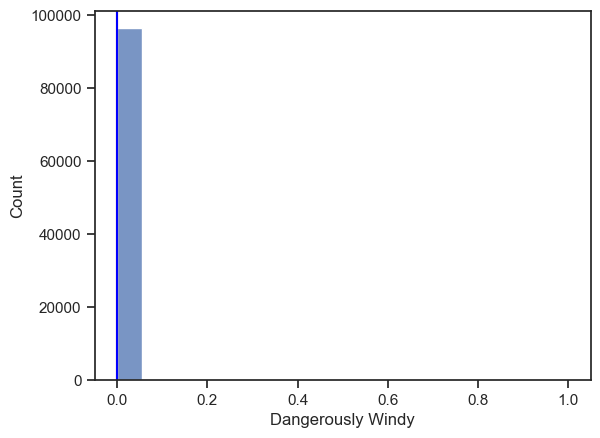

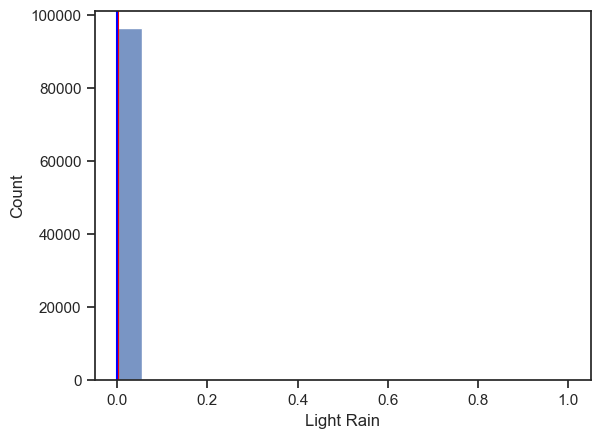

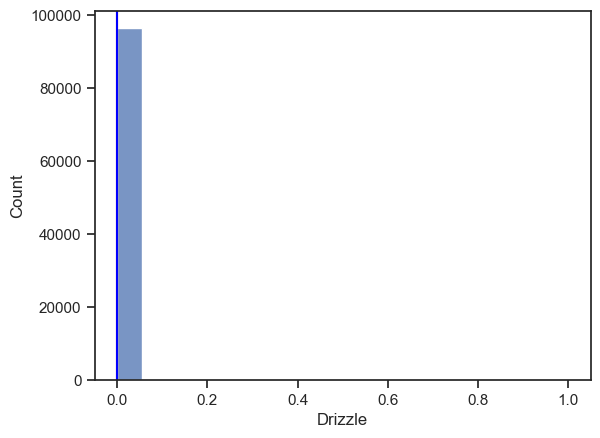

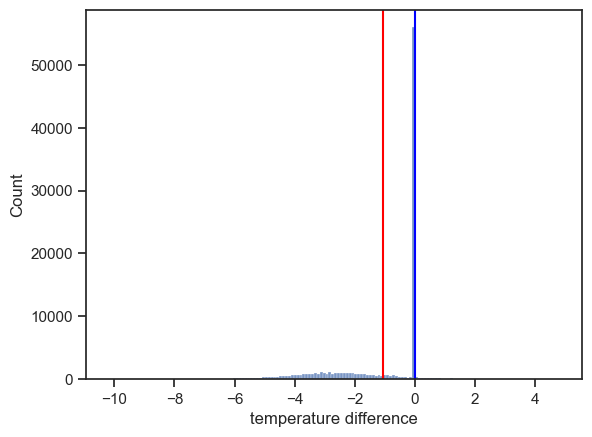

In [31]:
for feature in df:
    sns.histplot(df, x=feature)
    plt.axvline(x=df[feature].mean(), color='red')
    plt.axvline(x=df[feature].median(), color='blue')
    plt.show()

## Wykrycie i zamiana wartości odstających

In [32]:
column_num = ['Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'temperature difference']

for col in column_num:
    high_3sigm = df[col].mean() + 3*df[col].std()
    low_3sigm = df[col].mean() - 3*df[col].std()
    print(f"Column name: {col}\n3-sigm max {high_3sigm}\t3-sigm min {low_3sigm}")
    print(f"Max for {col}: {df[col].max()}\tMin for {col}: {df[col].min()}")
    print("Outliers to replace:", len(df.loc[df[col] < low_3sigm]) + len(df.loc[df[col] > high_3sigm]))
    df.loc[df[col] < low_3sigm, col] = low_3sigm
    df.loc[df[col] > high_3sigm, col] = high_3sigm
    print("Outliers number:", len(df.loc[df[col] < low_3sigm]) + len(df.loc[df[col] > high_3sigm]))
    print("")

Column name: Humidity
3-sigm max 1.3213171835376154	3-sigm min 0.14848074913425569
Max for Humidity: 1.0	Min for Humidity: 0.0
Outliers to replace: 28
Outliers number: 0

Column name: Wind Speed (km/h)
3-sigm max 31.551353178570416	3-sigm min -9.930072896982493
Max for Wind Speed (km/h): 63.8526	Min for Wind Speed (km/h): 0.0
Outliers to replace: 1208
Outliers number: 0

Column name: Wind Bearing (degrees)
3-sigm max 509.65951761803706	3-sigm min -134.64105266619524
Max for Wind Bearing (degrees): 359.0	Min for Wind Bearing (degrees): 0.0
Outliers to replace: 0
Outliers number: 0

Column name: Visibility (km)
3-sigm max 22.923694503508923	3-sigm min -2.229044645028626
Max for Visibility (km): 16.1	Min for Visibility (km): 0.0
Outliers to replace: 0
Outliers number: 0

Column name: Pressure (millibars)
3-sigm max 1354.1456729018912	3-sigm min 652.3262388064024
Max for Pressure (millibars): 1046.38	Min for Pressure (millibars): 0.0
Outliers to replace: 1288
Outliers number: 0

Column nam

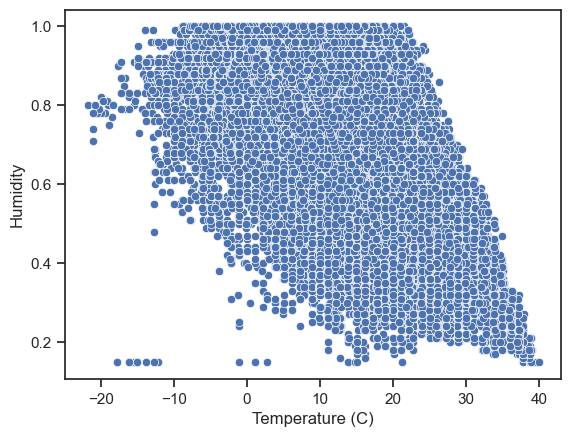

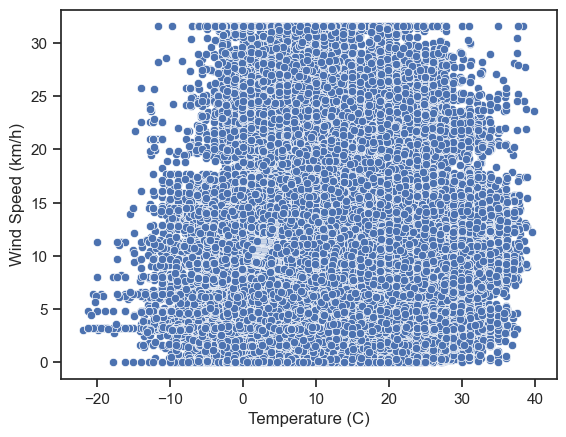

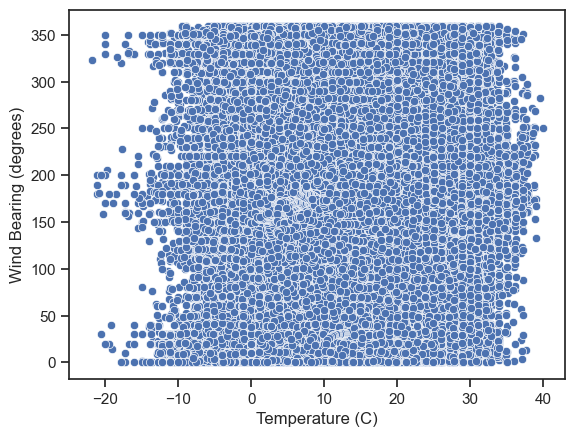

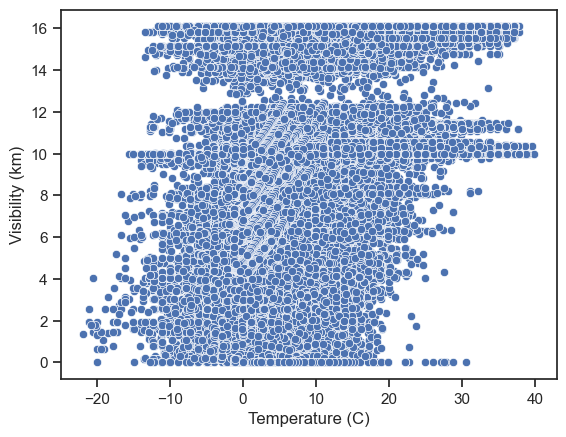

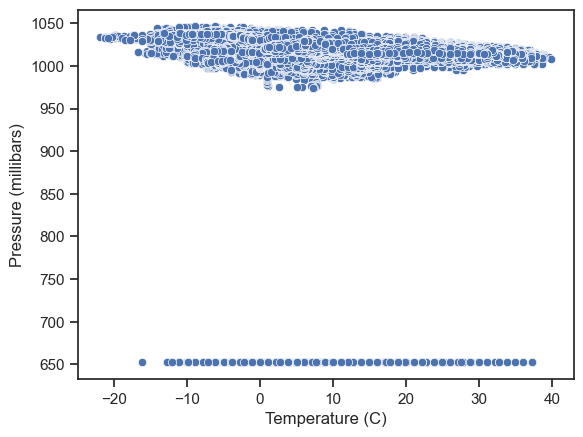

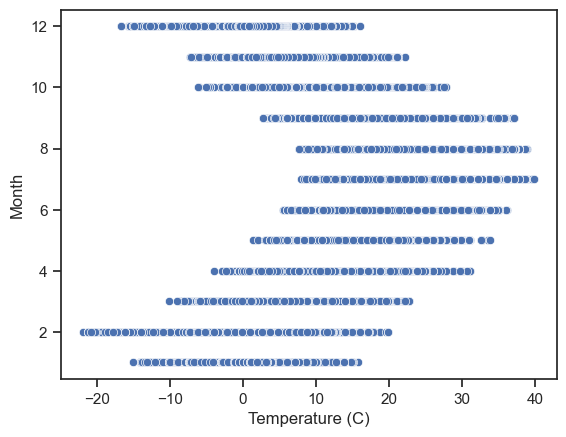

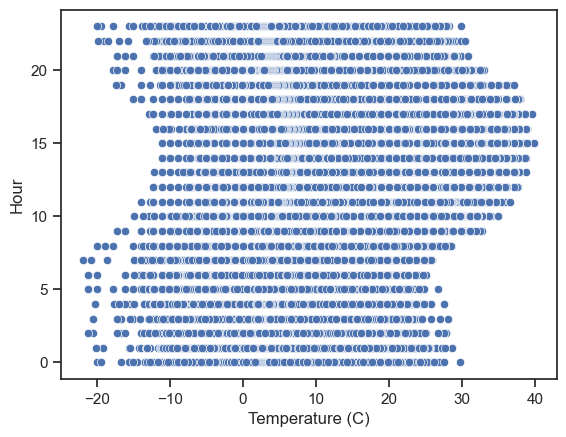

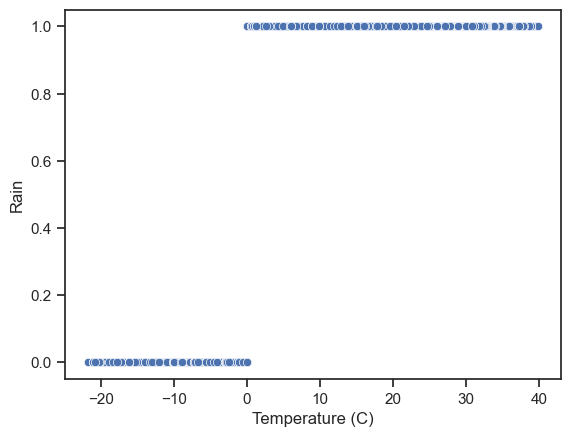

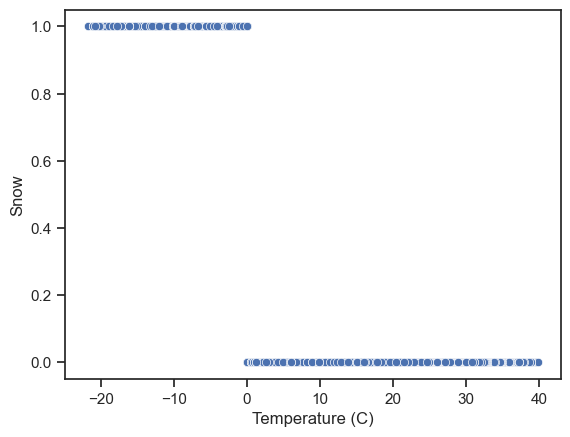

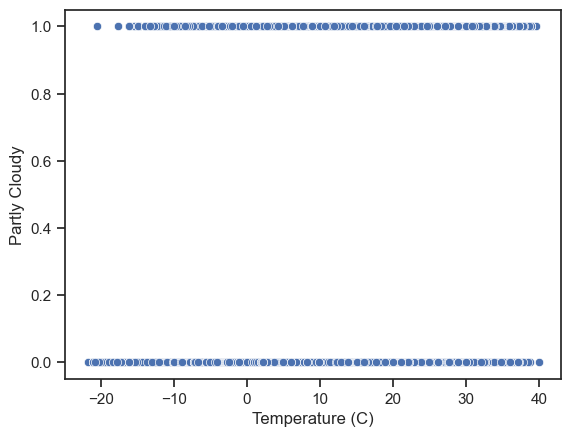

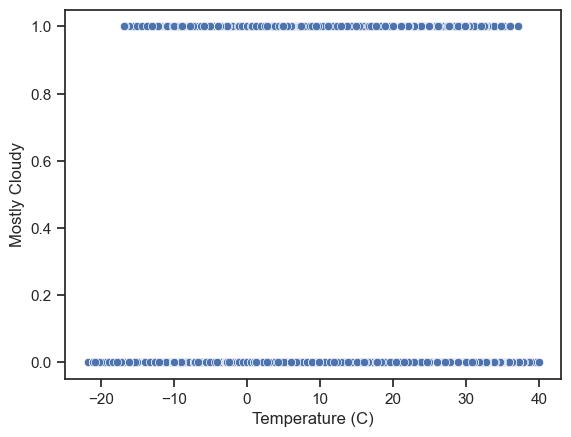

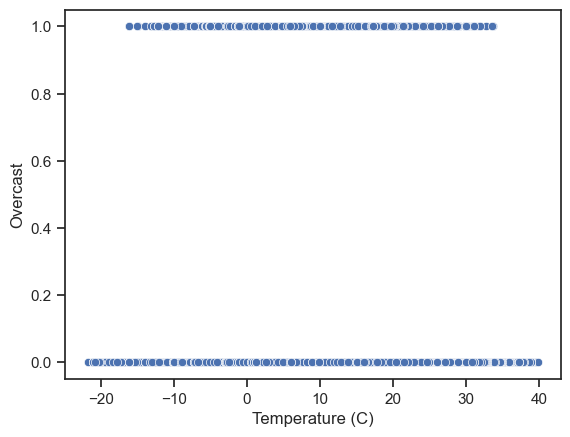

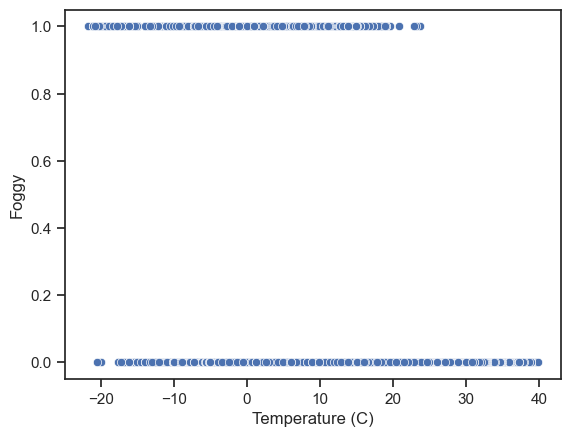

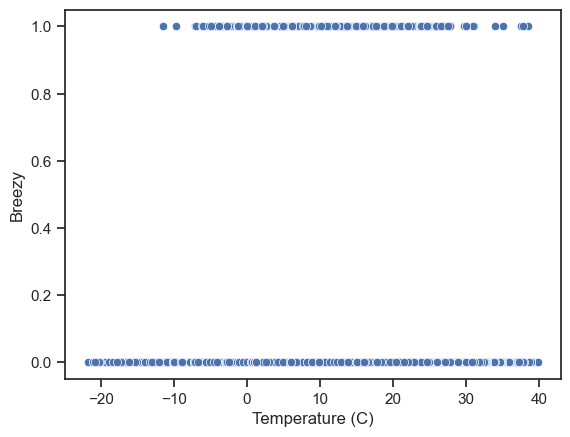

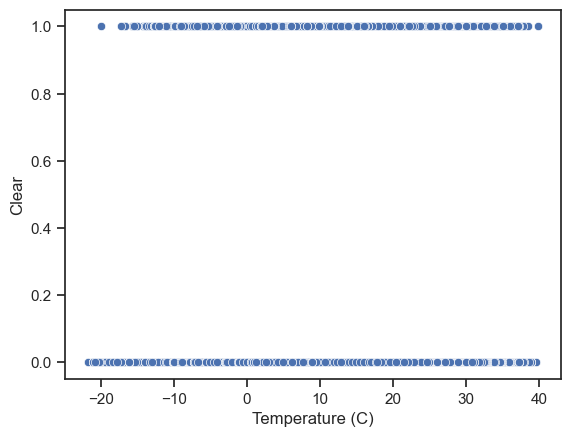

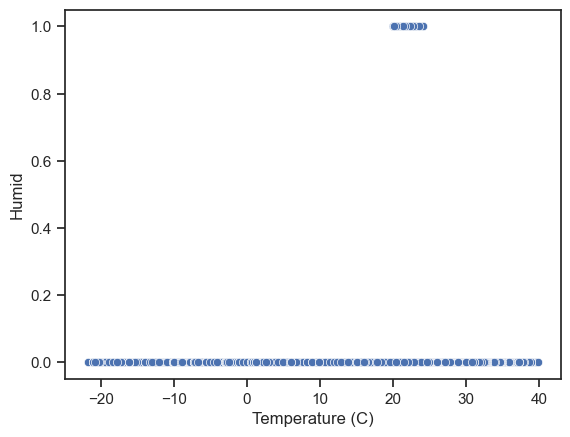

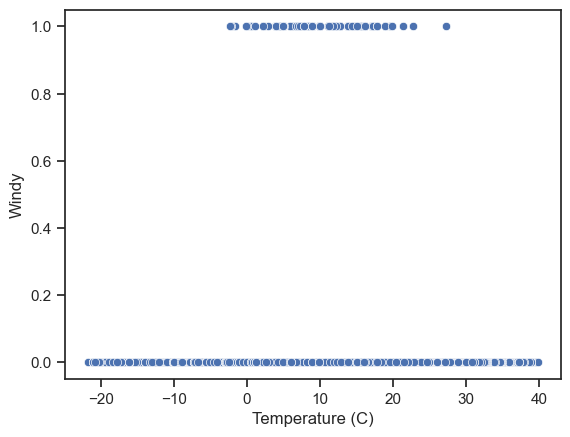

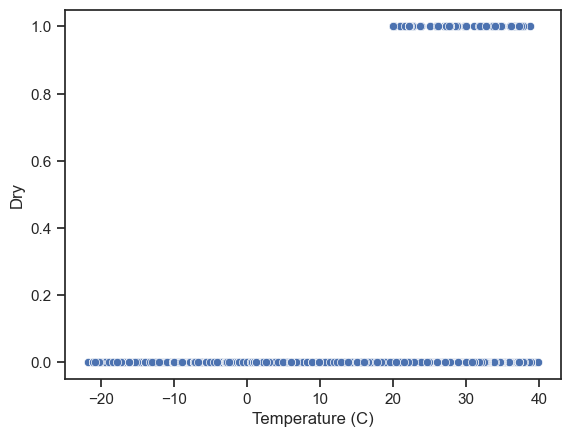

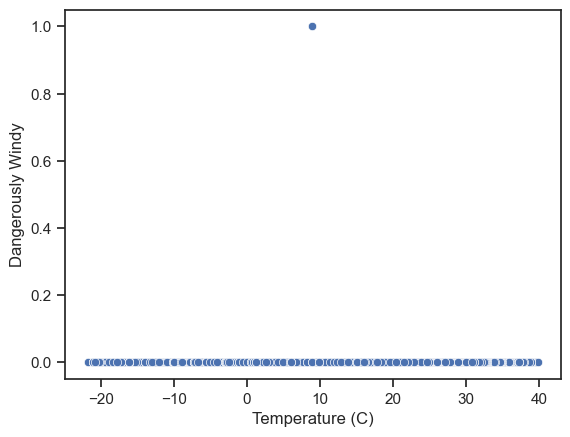

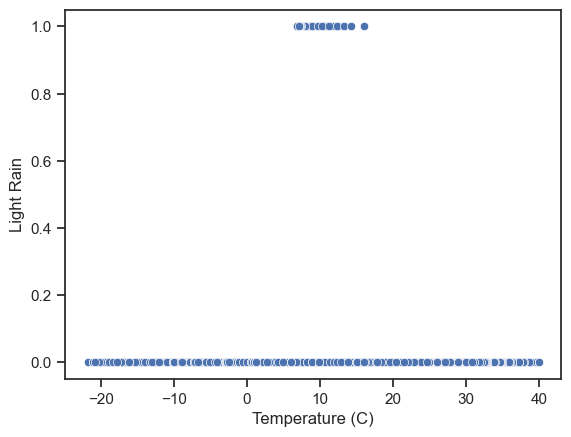

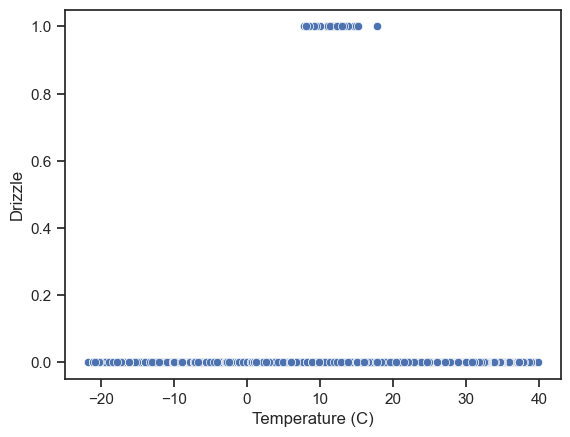

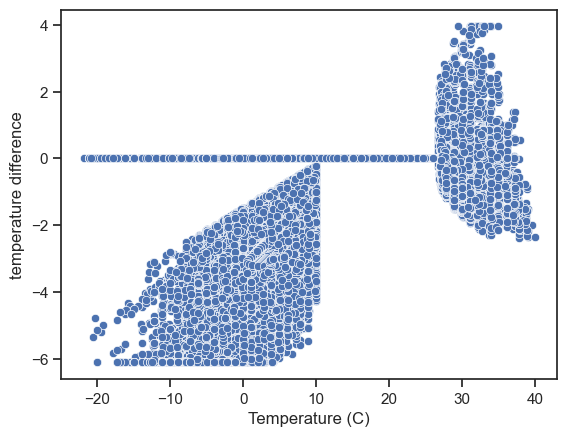

In [33]:
for col in df.drop(columns = ["Temperature (C)"]):
    sns.scatterplot(data=df, x="Temperature (C)", y= col)
    plt.show()